# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files
%matplotlib inline


In [4]:
# data containing defect images with segmentation mask
defect_class_mask_df = pd.read_csv('train (1).csv')


In [5]:
# data containing defective and non defective images
all_images_df = pd.read_csv('defect_and_no_defect.csv')


EncodedPixels column is the encoding of the segmentation using RLE or "Run Length Encoding". This is a lossless data compression technique which stores sequences that contain many consecutive data element as a signle value followed by the occurence count.

In [6]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
3732,ada3dacbe.jpg,3,172769 32 172961 96 173153 160 173345 4576 177...
3733,d74442547.jpg,3,47781 2 48033 6 48286 9 48538 13 48792 15 4904...
3734,9f2b5e50a.jpg,3,129255 26 129460 77 129665 128 129870 179 1300...
3735,a430d56ba.jpg,3,199628 53 199831 106 200087 106 200343 106 200...


The ClassId column indicates which type of defect is found on corresponding image.

In [7]:
set(defect_class_mask_df.ClassId)

{1, 2, 3, 4}

In [8]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


The label column indicates whether there is a defect or not for the corresponding image

In [9]:
set(all_images_df.label)

{0, 1}

In [10]:
all_images_df.label.sum()

7095

There are over 7,000 images with a defect in our dataset of nearly 13,000 images

# VISUALIZE AND EXPLORE DATASET

In [11]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [12]:
defect_class_mask_df.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


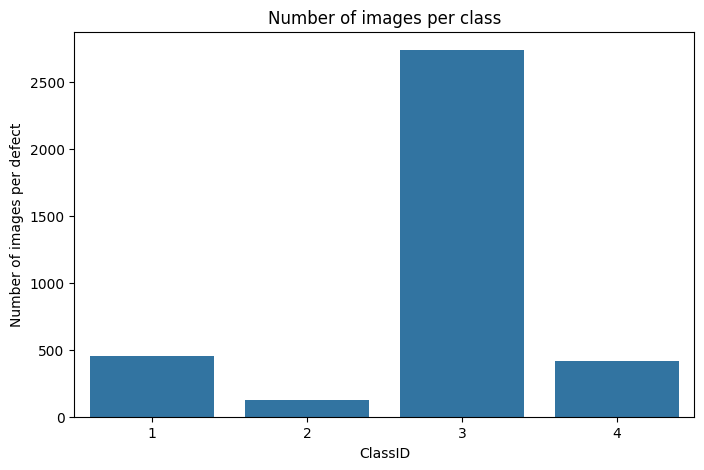

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(data= defect_class_mask_df, x='ClassId')
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')
plt.show()

The defect type 3 is over-represented vs the other types. This can penalize the classification performance during training.
- Class 3 represents 73% of the defects